# Description
Predict named entity from given data and showcase how entities like persons, locations, organizations, and
other miscellaneous entity names of that do not belong to the previous three groups can be predicted from
the tagged dataset. 

# Problem Statement
Using CoNLL 2003 data, predict tagged NER using CRF Algorithm. Also, tune the algorithm and explore the
learnings that have been done by the CRF Model. 

# Dataset
The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been
put on a separate line, and there is an empty line after each sentence. The first item on each line is a word,
the second a part-of-speech (POS) tag, the third a syntactic chunk tag, and the fourth the named entity tag.
The chunk tags and the named entity tags have the format I-TYPE, which means that the word is inside a
phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the
second phrase will have tag B-TYPE to show that it starts a new phrase. A word with tag O is not part of a
phrase. 

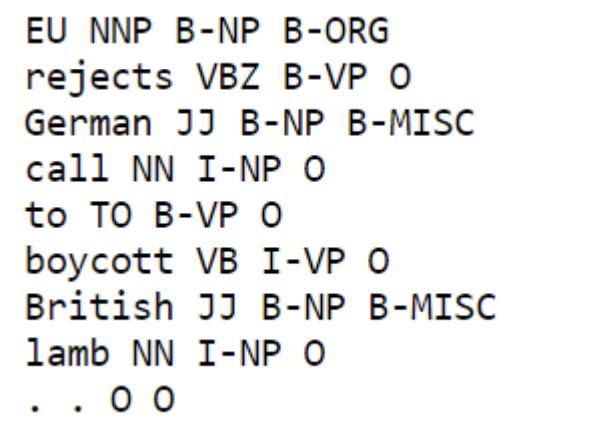

Source: https://www.clips.uantwerpen.be/conll2003/ner/ 

# Different Classes
1. persons, (PER)
2. locations, (LOC)
3. Organizations (ORG),
4. names of miscellaneous entities that do not belong to the previous three groups (MISC) 

# Question 1.1 - Text Processing

In [1]:
#download ConLL 2003 training and test data
!wget https://raw.githubusercontent.com/davidsbatista/NER-datasets/master/CONLL2003/train.txt
!wget https://raw.githubusercontent.com/davidsbatista/NER-datasets/master/CONLL2003/test.txt

--2021-03-23 04:48:55--  https://raw.githubusercontent.com/davidsbatista/NER-datasets/master/CONLL2003/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3283418 (3.1M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   3.13M  19.9MB/s    in 0.2s    

2021-03-23 04:48:55 (19.9 MB/s) - ‘train.txt’ saved [3283418/3283418]

--2021-03-23 04:48:55--  https://raw.githubusercontent.com/davidsbatista/NER-datasets/master/CONLL2003/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748093 (731

In [2]:
#function to pre-process and convert the text to required format
def text_preprocess(filepath):
  data_read = []
  final_data = []
  file = open(filepath, mode='r') #open the text file in read mode
  text_content = file.read() #read the file content

  #split the content by line and append to a list
  for line in text_content.split('\n'):
    data_read.append(line)

  #add a line break after each sentence and delete the first line which is not required
  for i in range(len(data_read)):
    if data_read[i] == '':
      data_read[i] = '\n'
  del data_read[0:2]

  #create an internal sub-list of each sentence
  n = 0
  for m in range(len(data_read)):
    if data_read[m] == '\n':
      final_data.append(data_read[n:m])
      n = m+1

  #split the words in sub-list and group each word along with its properties into tuple 
  for k in range(len(final_data)):
    for l in range(len(final_data[k])):
      split_words = tuple(final_data[k][l].split())
      final_data[k][l] = split_words

  return final_data

In [4]:
#process the train data and print few entries
train_data = text_preprocess('/content/train.txt')
train_data[0:3]

#process the test data
test_data = text_preprocess('/content/test.txt')
test_data[0:3]

[[('SOCCER', 'NN', 'B-NP', 'O'),
  ('-', ':', 'O', 'O'),
  ('JAPAN', 'NNP', 'B-NP', 'B-LOC'),
  ('GET', 'VB', 'B-VP', 'O'),
  ('LUCKY', 'NNP', 'B-NP', 'O'),
  ('WIN', 'NNP', 'I-NP', 'O'),
  (',', ',', 'O', 'O'),
  ('CHINA', 'NNP', 'B-NP', 'B-PER'),
  ('IN', 'IN', 'B-PP', 'O'),
  ('SURPRISE', 'DT', 'B-NP', 'O'),
  ('DEFEAT', 'NN', 'I-NP', 'O'),
  ('.', '.', 'O', 'O')],
 [('Nadim', 'NNP', 'B-NP', 'B-PER'), ('Ladki', 'NNP', 'I-NP', 'I-PER')],
 [('AL-AIN', 'NNP', 'B-NP', 'B-LOC'),
  (',', ',', 'O', 'O'),
  ('United', 'NNP', 'B-NP', 'B-LOC'),
  ('Arab', 'NNP', 'I-NP', 'I-LOC'),
  ('Emirates', 'NNPS', 'I-NP', 'I-LOC'),
  ('1996-12-06', 'CD', 'I-NP', 'O')]]

# Feature Extraction

In [5]:
'''function to convert text into features
Features like:
1. word parts
2. Whether it is title
3. Digit
4. Upper case or a lower case
We convert them into sklearn-crfsuite format so that it becomes easy for the package to read the data

Each sentence is converted to a list of dicts'''

def text2features(text, index):
    word = text[index][0]
    pos_tag = text[index][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'pos_tag': pos_tag,
        'pos_tag[:2]': pos_tag[:2],
    }
    if index > 0:
        word_next = text[index-1][0]
        pos_tag_next = text[index-1][1]
        features.update({
            '-1:word.lower()': word_next.lower(),
            '-1:word.istitle()': word_next.istitle(),
            '-1:word.isupper()': word_next.isupper(),
            '-1:pos_tag': pos_tag_next,
            '-1:pos_tag[:2]': pos_tag_next[:2],
        })
    else:
        features['BOS'] = True

    if index < len(text)-1:
        word_next = text[index+1][0]
        pos_tag_next = text[index+1][1]
        features.update({
            '+1:word.lower()': word_next.lower(),
            '+1:word.istitle()': word_next.istitle(),
            '+1:word.isupper()': word_next.isupper(),
            '+1:pos_tag': pos_tag_next,
            '+1:pos_tag[:2]': pos_tag_next[:2],
        })
    else:
        features['EOS'] = True

    return features

In [6]:
#function to apply text2features to entire text
def text_to_features_all(text):
    return [text2features(text, index) for index in range(len(text))]

In [7]:
#function to extract lables from text
def text_to_labels(text):
    return [label for word, postag, chunk, label in text]

In [9]:
#assigning features to X and labels to y
X_train = [text_to_features_all(text) for text in train_data]
X_test = [text_to_features_all(text) for text in test_data]

y_train = [text_to_labels(text) for text in train_data]
y_test = [text_to_labels(text) for text in test_data]

print(len(X_train), len(y_train), len(X_test), len(y_test))

14985 14985 3682 3682


# Question 1.2 - Building a CRF Model

In [12]:
#import libraries
!pip install eli5
!pip install sklearn_crfsuite
import pandas as pd
import numpy as np
import eli5 as el
from sklearn_crfsuite import CRF as crf
from sklearn_crfsuite.metrics import flat_classification_report as fcr

     |████████████████████████████████| 747kB 7.1MB/s 


In [13]:
#define the CRF model
crf_model1 = crf(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)

In [14]:
#fit the model
crf_model1.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [15]:
#predict on test data
y_pred = crf_model1.predict(X_test)

In [17]:
#classification report
report = fcr(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       B-LOC       0.86      0.81      0.83      1667
      B-MISC       0.81      0.76      0.79       701
       B-ORG       0.77      0.73      0.75      1660
       B-PER       0.82      0.86      0.84      1616
       I-LOC       0.74      0.60      0.67       257
      I-MISC       0.68      0.66      0.67       214
       I-ORG       0.67      0.74      0.70       834
       I-PER       0.87      0.95      0.91      1156
           O       0.99      0.99      0.99     38519

    accuracy                           0.96     46624
   macro avg       0.80      0.79      0.79     46624
weighted avg       0.96      0.96      0.96     46624



In [19]:
#remove "O" category from labels and check the report
labels = list(crf_model1.classes_)
labels.remove("O")

report1 = fcr(y_test, y_pred, labels=labels)
print(report1)

              precision    recall  f1-score   support

       B-ORG       0.77      0.73      0.75      1660
      B-MISC       0.81      0.76      0.79       701
       B-PER       0.82      0.86      0.84      1616
       I-PER       0.87      0.95      0.91      1156
       B-LOC       0.86      0.81      0.83      1667
       I-ORG       0.67      0.74      0.70       834
      I-MISC       0.68      0.66      0.67       214
       I-LOC       0.74      0.60      0.67       257

   micro avg       0.80      0.80      0.80      8105
   macro avg       0.78      0.76      0.77      8105
weighted avg       0.80      0.80      0.80      8105



# Question 1.3 - RandomizedSearchCV

In [29]:
from sklearn.model_selection import RandomizedSearchCV
import scipy  
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer

In [30]:
#define fixed parameters and parameters to search

crf_model2 = crf(algorithm='lbfgs', 
                 max_iterations=100, 
                 all_possible_transitions=True)

params_space = {
    'c1': scipy.stats.expon(scale=0.5), 
    'c2': scipy.stats.expon(scale=0.5)
}

#set the scoring parameter
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)

In [32]:
#define and fit RandomizedSearchCV
rs = RandomizedSearchCV(crf_model2, params_space, n_iter=50, scoring=f1_scorer, n_jobs=-1, cv=3, verbose=1)
rs.fit(X_train, y_train)

print('Best params:', rs.best_params_)
print('Best CV score:', rs.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 70.8min finished


Best params: {'c1': 0.004317600975536076, 'c2': 0.05335066690299821}
Best CV score: 0.8487767822558486


# Question 1.4 - Best Model, Transition and State Features

In [33]:
#will use the best model on test data
crf_best = rs.best_estimator_
y_predicted = crf_best.predict(X_test)

print(fcr(y_test, y_predicted, labels=labels, digits=3))

              precision    recall  f1-score   support

       B-ORG      0.780     0.734     0.757      1660
      B-MISC      0.807     0.765     0.785       701
       B-PER      0.841     0.851     0.846      1616
       I-PER      0.886     0.951     0.917      1156
       B-LOC      0.856     0.831     0.843      1667
       I-ORG      0.662     0.751     0.704       834
      I-MISC      0.668     0.659     0.664       214
       I-LOC      0.763     0.650     0.702       257

   micro avg      0.809     0.808     0.808      8105
   macro avg      0.783     0.774     0.777      8105
weighted avg      0.810     0.808     0.808      8105



In [35]:
#getting the top5 transition features
from collections import Counter

def print_transitions(trans_features):
  for (label_from, label_to), weight in trans_features:
    print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top 5 likely Transitions:")
print_transitions(Counter(crf_best.transition_features_).most_common(5))

Top 5 likely Transitions:
B-MISC -> I-MISC  5.623484
I-MISC -> I-MISC  5.384399
B-PER  -> I-PER   5.044064
B-LOC  -> I-LOC   4.889888
I-LOC  -> I-LOC   4.572488


In [37]:
#getting the top5 state features
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top 5 positive:")
print_state_features(Counter(crf_best.state_features_).most_common(5))

Top 5 positive:
7.416859 B-LOC    word.lower():chester-le-street
6.695935 I-LOC    -1:word.lower():colo
6.678627 I-LOC    -1:word.lower():wisc
6.386062 B-ORG    word.lower():sungard
6.252187 B-ORG    -1:word.lower():v
